# Capstone Model Development with AWS Sagemaker Built-in Algorithms: Model HPO

1. Notebook should be using a `ml.t3.medium` instance (2 vCPU + 4 GiB)
2. Notebook should be using kernal: `Python 3 (MXNet 1.8 Python 3.7 CPU Optimized)`

### Install packages

In [2]:
!pip install sagemaker ipywidgets --upgrade --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytest-astropy 0.8.0 requires pytest-cov>=2.0, which is not installed.
pytest-astropy 0.8.0 requires pytest-filter-subpackage>=0.1, which is not installed.
sparkmagic 0.20.4 requires nest-asyncio==1.5.5, but you have nest-asyncio 1.5.6 which is incompatible.
awscli 1.27.96 requires rsa<4.8,>=3.1.2, but you have rsa 4.9 which is incompatible.


In [3]:
!pip install bokeh

In [4]:
import bokeh

In [5]:
import sagemaker, boto3, json
from sagemaker import get_execution_role

aws_role = get_execution_role()
aws_region = boto3.Session().region_name
sess = sagemaker.Session()

In [6]:
import pandas as pd

In [14]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
local_data_path = "cleaned.csv"
dataset = pd.read_csv(local_data_path)
dataset.head()

,Unnamed: 0,age_upon_outcome,animal_id_outcome,date_of_birth,outcome_type,sex_upon_outcome,age_upon_outcome_(days),age_upon_outcome_(years),age_upon_outcome_age_group,outcome_datetime,...,age_upon_intake_(days),age_upon_intake_(years),age_upon_intake_age_group,intake_datetime,intake_month,intake_year,intake_weekday,intake_hour,intake_number,time_in_shelter_days
0,0,10 years,A006100,2007-07-09 00:00:00,Not Adopted,Neutered Male,3650,10.0,"(7.5, 10.0]",2017-12-07 14:07:00,...,3650,10.0,"(7.5, 10.0]",2017-12-07 00:00:00,12,2017,Thursday,14,1.0,0.588194
1,1,7 years,A006100,2007-07-09 00:00:00,Not Adopted,Neutered Male,2555,7.0,"(5.0, 7.5]",2014-12-20 16:35:00,...,2555,7.0,"(5.0, 7.5]",2014-12-19 10:21:00,12,2014,Friday,10,2.0,1.259722
2,2,6 years,A006100,2007-07-09 00:00:00,Not Adopted,Neutered Male,2190,6.0,"(5.0, 7.5]",2014-03-08 17:10:00,...,2190,6.0,"(5.0, 7.5]",2014-03-07 14:26:00,3,2014,Friday,14,3.0,1.113889
3,3,10 years,A047759,2004-04-02 00:00:00,Not Adopted,Neutered Male,3650,10.0,"(7.5, 10.0]",2014-04-07 15:12:00,...,3650,10.0,"(7.5, 10.0]",2014-04-02 15:55:00,4,2014,Wednesday,15,1.0,4.970139
4,4,16 years,A134067,1997-10-16 00:00:00,Not Adopted,Neutered Male,5840,16.0,"(15.0, 17.5]",2013-11-16 11:54:00,...,5840,16.0,"(15.0, 17.5]",2013-11-16 09:02:00,11,2013,Saturday,9,1.0,0.119444


In [15]:
dataset.dropna(inplace=True)

In [16]:
temp_cols= dataset.columns.tolist()
index= dataset.columns.get_loc("outcome_type")

In [17]:
new_cols= temp_cols[index:index+1] + temp_cols[0:index] + temp_cols[index+1:]

In [18]:
dataset=dataset[new_cols]

In [19]:
dataset.head()

,outcome_type,Unnamed: 0,age_upon_outcome,animal_id_outcome,date_of_birth,sex_upon_outcome,age_upon_outcome_(days),age_upon_outcome_(years),age_upon_outcome_age_group,outcome_datetime,...,age_upon_intake_(days),age_upon_intake_(years),age_upon_intake_age_group,intake_datetime,intake_month,intake_year,intake_weekday,intake_hour,intake_number,time_in_shelter_days
0,Not Adopted,0,10 years,A006100,2007-07-09 00:00:00,Neutered Male,3650,10.0,"(7.5, 10.0]",2017-12-07 14:07:00,...,3650,10.0,"(7.5, 10.0]",2017-12-07 00:00:00,12,2017,Thursday,14,1.0,0.588194
1,Not Adopted,1,7 years,A006100,2007-07-09 00:00:00,Neutered Male,2555,7.0,"(5.0, 7.5]",2014-12-20 16:35:00,...,2555,7.0,"(5.0, 7.5]",2014-12-19 10:21:00,12,2014,Friday,10,2.0,1.259722
2,Not Adopted,2,6 years,A006100,2007-07-09 00:00:00,Neutered Male,2190,6.0,"(5.0, 7.5]",2014-03-08 17:10:00,...,2190,6.0,"(5.0, 7.5]",2014-03-07 14:26:00,3,2014,Friday,14,3.0,1.113889
3,Not Adopted,3,10 years,A047759,2004-04-02 00:00:00,Neutered Male,3650,10.0,"(7.5, 10.0]",2014-04-07 15:12:00,...,3650,10.0,"(7.5, 10.0]",2014-04-02 15:55:00,4,2014,Wednesday,15,1.0,4.970139
4,Not Adopted,4,16 years,A134067,1997-10-16 00:00:00,Neutered Male,5840,16.0,"(15.0, 17.5]",2013-11-16 11:54:00,...,5840,16.0,"(15.0, 17.5]",2013-11-16 09:02:00,11,2013,Saturday,9,1.0,0.119444


In [20]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79661 entries, 0 to 79671
Data columns (total 36 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   outcome_type                79661 non-null  object 
 1   Unnamed: 0                  79661 non-null  int64  
 2   age_upon_outcome            79661 non-null  object 
 3   animal_id_outcome           79661 non-null  object 
 4   date_of_birth               79661 non-null  object 
 5   sex_upon_outcome            79661 non-null  object 
 6   age_upon_outcome_(days)     79661 non-null  int64  
 7   age_upon_outcome_(years)    79661 non-null  float64
 8   age_upon_outcome_age_group  79661 non-null  object 
 9   outcome_datetime            79661 non-null  object 
 10  outcome_month               79661 non-null  int64  
 11  outcome_year                79661 non-null  int64  
 12  outcome_weekday             79661 non-null  object 
 13  outcome_hour                796

In [21]:
dataset.drop('Unnamed: 0', axis=1, inplace=True)
dataset.drop('animal_id_outcome', axis=1, inplace=True)
dataset.drop('age_upon_outcome_age_group', axis=1, inplace=True)
dataset.drop('outcome_number', axis=1, inplace=True)

In [22]:
dataset.drop('animal_id_intake', axis=1, inplace=True)
dataset.drop('age_upon_intake_age_group', axis=1, inplace=True)
dataset.drop('intake_number', axis=1, inplace=True)

In [23]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79661 entries, 0 to 79671
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   outcome_type              79661 non-null  object 
 1   age_upon_outcome          79661 non-null  object 
 2   date_of_birth             79661 non-null  object 
 3   sex_upon_outcome          79661 non-null  object 
 4   age_upon_outcome_(days)   79661 non-null  int64  
 5   age_upon_outcome_(years)  79661 non-null  float64
 6   outcome_datetime          79661 non-null  object 
 7   outcome_month             79661 non-null  int64  
 8   outcome_year              79661 non-null  int64  
 9   outcome_weekday           79661 non-null  object 
 10  outcome_hour              79661 non-null  int64  
 11  dob_year                  79661 non-null  int64  
 12  dob_month                 79661 non-null  int64  
 13  age_upon_intake           79661 non-null  object 
 14  animal

In [24]:
dataset['outcome_type'] = dataset['outcome_type'].astype('category')
dataset['sex_upon_outcome'] = dataset['sex_upon_outcome'].astype('category')
dataset['outcome_weekday'] = dataset['outcome_weekday'].astype('category')
dataset['animal_type'] = dataset['animal_type'].astype('category')
dataset['breed'] = dataset['breed'].astype('category')
dataset['color'] = dataset['color'].astype('category')
dataset['intake_condition'] = dataset['intake_condition'].astype('category')
dataset['intake_type'] = dataset['intake_type'].astype('category')
dataset['sex_upon_intake'] = dataset['sex_upon_intake'].astype('category')

In [25]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79661 entries, 0 to 79671
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   outcome_type              79661 non-null  category
 1   age_upon_outcome          79661 non-null  object  
 2   date_of_birth             79661 non-null  object  
 3   sex_upon_outcome          79661 non-null  category
 4   age_upon_outcome_(days)   79661 non-null  int64   
 5   age_upon_outcome_(years)  79661 non-null  float64 
 6   outcome_datetime          79661 non-null  object  
 7   outcome_month             79661 non-null  int64   
 8   outcome_year              79661 non-null  int64   
 9   outcome_weekday           79661 non-null  category
 10  outcome_hour              79661 non-null  int64   
 11  dob_year                  79661 non-null  int64   
 12  dob_month                 79661 non-null  int64   
 13  age_upon_intake           79661 non-null  obje

In [26]:
dataset.drop('date_of_birth', axis=1, inplace=True)
dataset.drop('age_upon_outcome_(days)', axis=1, inplace=True)
dataset.drop('outcome_datetime', axis=1, inplace=True)
dataset.drop('dob_year', axis=1, inplace=True)
dataset.drop('dob_month', axis=1, inplace=True)
dataset.drop('age_upon_intake_(days)', axis=1, inplace=True)
dataset.drop('intake_datetime', axis=1, inplace=True)

In [27]:
dataset.drop('age_upon_outcome', axis=1, inplace=True)

In [28]:
dataset.drop('age_upon_intake', axis=1, inplace=True)

In [29]:
dataset.drop('time_in_shelter_days', axis=1, inplace=True)

In [30]:
dataset['found_location'] = dataset['found_location'].astype('category')
dataset['intake_weekday'] = dataset['intake_weekday'].astype('category')

In [31]:
dataset['outcome_month'] = dataset['outcome_month'].astype('int32')
dataset['outcome_year'] = dataset['outcome_year'].astype('int32')
dataset['outcome_hour'] = dataset['outcome_hour'].astype('int32')
dataset['intake_month'] = dataset['intake_month'].astype('int32')
dataset['intake_year'] = dataset['intake_year'].astype('int32')
dataset['intake_hour'] = dataset['intake_hour'].astype('int32')

In [33]:
dataset['age_upon_outcome_(years)'] = dataset['age_upon_outcome_(years)'].astype('float32')
dataset['age_upon_intake_(years)'] = dataset['age_upon_intake_(years)'].astype('float32')

In [34]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79661 entries, 0 to 79671
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   outcome_type              79661 non-null  category
 1   sex_upon_outcome          79661 non-null  category
 2   age_upon_outcome_(years)  79661 non-null  float32 
 3   outcome_month             79661 non-null  int32   
 4   outcome_year              79661 non-null  int32   
 5   outcome_weekday           79661 non-null  category
 6   outcome_hour              79661 non-null  int32   
 7   animal_type               79661 non-null  category
 8   breed                     79661 non-null  category
 9   color                     79661 non-null  category
 10  found_location            79661 non-null  category
 11  intake_condition          79661 non-null  category
 12  intake_type               79661 non-null  category
 13  sex_upon_intake           79661 non-null  cate

In [48]:
from sklearn.preprocessing import LabelEncoder

In [49]:
columns=['outcome_type', 'sex_upon_outcome', 'outcome_weekday', 'animal_type', 'breed', 'color', 'found_location', 'intake_condition', 'intake_type', 'sex_upon_intake', 'intake_weekday']

In [50]:
def encoder(data):
    for col in columns:
        label_encoder = LabelEncoder()
        label_encoder.fit(data[col])
        data[col] = label_encoder.transform(data[col])
    return data

In [51]:
df_train = encoder(dataset)

In [52]:
df_train.head()

,outcome_type,sex_upon_outcome,age_upon_outcome_(years),outcome_month,outcome_year,outcome_weekday,outcome_hour,animal_type,breed,color,found_location,intake_condition,intake_type,sex_upon_intake,age_upon_intake_(years),intake_month,intake_year,intake_weekday,intake_hour
0,1,2,10.0,12,2017,4,0,2,1982,527,27351,3,3,2,10.0,12,2017,4,14
1,1,2,7.0,12,2014,2,16,2,1982,527,23499,3,2,2,7.0,12,2014,0,10
2,1,2,6.0,3,2014,2,17,2,1982,527,23500,3,2,2,6.0,3,2014,0,14
3,1,2,10.0,4,2014,1,15,2,830,449,25821,3,1,2,10.0,4,2014,6,15
4,1,2,16.0,11,2013,2,11,2,1880,183,3300,2,2,2,16.0,11,2013,2,9


In [53]:
df_train['outcome_type'] = dataset['outcome_type'].astype('int32')
df_train['sex_upon_outcome'] = dataset['sex_upon_outcome'].astype('int32')
df_train['outcome_weekday'] = dataset['outcome_weekday'].astype('int32')
df_train['animal_type'] = dataset['animal_type'].astype('int32')
df_train['breed'] = dataset['breed'].astype('int32')
df_train['color'] = dataset['color'].astype('int32')
df_train['intake_condition'] = dataset['intake_condition'].astype('int32')
df_train['intake_type'] = dataset['intake_type'].astype('int32')
df_train['sex_upon_intake'] = dataset['sex_upon_intake'].astype('int32')
df_train['found_location'] = dataset['found_location'].astype('int32')
df_train['intake_weekday'] = dataset['intake_weekday'].astype('int32')

In [58]:
df_train['age_upon_outcome_(years)'] = dataset['age_upon_outcome_(years)'].astype('int32')
df_train['age_upon_intake_(years)'] = dataset['age_upon_intake_(years)'].astype('int32')

In [59]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79661 entries, 0 to 79671
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   outcome_type              79661 non-null  int32
 1   sex_upon_outcome          79661 non-null  int32
 2   age_upon_outcome_(years)  79661 non-null  int32
 3   outcome_month             79661 non-null  int32
 4   outcome_year              79661 non-null  int32
 5   outcome_weekday           79661 non-null  int32
 6   outcome_hour              79661 non-null  int32
 7   animal_type               79661 non-null  int32
 8   breed                     79661 non-null  int32
 9   color                     79661 non-null  int32
 10  found_location            79661 non-null  int32
 11  intake_condition          79661 non-null  int32
 12  intake_type               79661 non-null  int32
 13  sex_upon_intake           79661 non-null  int32
 14  age_upon_intake_(years)   79661 non-nu

In [60]:
df_train.to_csv('data.csv')

Requirements: https://github.com/aws/amazon-sagemaker-examples/blob/main/introduction_to_amazon_algorithms/lightgbm_catboost_tabular/Amazon_Tabular_Classification_LightGBM_CatBoost.ipynb

The 'data.csv' files under sub-directory 'train/' and 'validation/' are for training and validation, respectively. The validation data is used to compute a validation score at the end of each boosting iteration. An early stopping is applied when the validation score stops improving. If the validation data is not provided, a 20% of training data is randomly sampled to serve as the validation data.

The first column of the 'data.csv' should have the corresponding target variable. The rest of other columns should have the corresponding predictor variables (features).

If the predictors include categorical feature(s), a json-format file named 'categorical_index.json' should be included in the input directory to indicate the column index(es) of the categorical features. Within the json-format file, it should have a python directory where the key is a string of 'cat_index_list' and the value is a list of unique integer(s). Each integer in the list indicates the column index of categorical features in the 'data.csv'. The range of each integer should be more than 0 (index 0 indicates the target) and less than the total number of columns.

All the categorical features and the target must be encoded as non-negative integers (int) less than Int32.MaxValue (2147483647). It is best to use a contiguous range of integers started from zero.

Note. The number of json-format files should be no more than 1 in the input directory.

Citations:

[LeCun et al., 1998a] Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. 'Gradient-based learning applied to document recognition.' Proceedings of the IEEE, 86(11):2278-2324, November 1998

In [2]:
import pandas as pd

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
from sklearn.preprocessing import LabelEncoder

In [5]:
data = pd.read_csv('data.csv')

In [43]:
data.drop(labels='Unnamed0', axis=1, inplace=True)

In [44]:
data.head()

,outcome_type,sex_upon_outcome,age_upon_outcome_years,outcome_month,outcome_year,outcome_weekday,outcome_hour,animal_type,breed,color,found_location,intake_condition,intake_type,sex_upon_intake,age_upon_intake_years,intake_month,intake_year,intake_weekday,intake_hour
1,1,2,7,12,2014,2,16,2,1982,527,23499,3,2,2,7,12,2014,0,10
2,1,2,6,3,2014,2,17,2,1982,527,23500,3,2,2,6,3,2014,0,14
3,1,2,10,4,2014,1,15,2,830,449,25821,3,1,2,10,4,2014,6,15
4,1,2,16,11,2013,2,11,2,1880,183,3300,2,2,2,16,11,2013,2,9
5,1,3,15,11,2013,3,11,2,1337,59,25821,0,3,3,15,11,2013,2,14


In [45]:
import re
data = data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [46]:
data.head()

,outcome_type,sex_upon_outcome,age_upon_outcome_years,outcome_month,outcome_year,outcome_weekday,outcome_hour,animal_type,breed,color,found_location,intake_condition,intake_type,sex_upon_intake,age_upon_intake_years,intake_month,intake_year,intake_weekday,intake_hour
1,1,2,7,12,2014,2,16,2,1982,527,23499,3,2,2,7,12,2014,0,10
2,1,2,6,3,2014,2,17,2,1982,527,23500,3,2,2,6,3,2014,0,14
3,1,2,10,4,2014,1,15,2,830,449,25821,3,1,2,10,4,2014,6,15
4,1,2,16,11,2013,2,11,2,1880,183,3300,2,2,2,16,11,2013,2,9
5,1,3,15,11,2013,3,11,2,1337,59,25821,0,3,3,15,11,2013,2,14


In [47]:
x_train, x_val, y_train, y_val = train_test_split(data.drop('outcome_type', axis=1), data['outcome_type'], test_size=0.2, random_state=42)

In [48]:
x_train.head()

,sex_upon_outcome,age_upon_outcome_years,outcome_month,outcome_year,outcome_weekday,outcome_hour,animal_type,breed,color,found_location,intake_condition,intake_type,sex_upon_intake,age_upon_intake_years,intake_month,intake_year,intake_weekday,intake_hour
35680,2,0,7,2015,3,16,1,952,59,2046,3,3,1,0,6,2015,5,11
18829,3,1,7,2014,1,16,2,1741,405,14768,3,3,0,1,7,2014,4,16
56227,0,0,9,2016,1,18,2,1452,56,5881,3,3,0,0,9,2016,1,15
28390,3,14,2,2015,0,0,2,1788,449,25044,3,3,3,14,2,2015,4,18
61142,2,0,1,2017,5,17,1,952,330,4787,3,3,1,0,12,2016,4,10


In [49]:
le = LabelEncoder()

In [9]:
y_train = le.fit_transform(y_train)

In [10]:
y_val = le.transform(y_val)

In [11]:
hyperparameters_sklearn = {
    'boosting_type': ['gbdt', 'dart', 'goss'],
    'num_leaves': range(2, 201),
    'learning_rate': [0.001, 0.01, 0.1],
    'min_child_weight': [0.01, 0.1, 1, 10],
    'subsample': [0.1, 0.5, 1.0],
    'colsample_bytree': [0.1, 0.5, 1.0],
    'reg_lambda': [0.1, 1, 10]
}

In [12]:
from sklearn.model_selection import RandomizedSearchCV

In [14]:
!pip install lightgbm

  Using cached lightgbm-3.3.5-py3-none-manylinux1_x86_64.whl (2.0 MB)


In [16]:
import lightgbm as lgb

In [17]:
clf = lgb.LGBMClassifier()

In [50]:
search = RandomizedSearchCV(clf,
                            hyperparameters_sklearn,
                            n_iter=10,
                            cv=5,
                            random_state=42,
                            scoring='roc_auc',
                            n_jobs=-1)

In [51]:
search.fit(x_train, y_train, eval_metric='auc')

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_leaves=31, objective=None,
                                            random_state=None, reg_alpha=0.0,
                                            reg_lambda=0.0, sile...
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributions={'boosting_type': ['gbdt', 

In [20]:
print('Best hyperparameters: ', search.best_params_)

Best hyperparameters:  {'subsample': 1.0, 'reg_lambda': 1, 'num_leaves': 180, 'min_child_weight': 0.1, 'learning_rate': 0.1, 'colsample_bytree': 0.5, 'boosting_type': 'dart'}


In [21]:
print('Best AUC score: ', search.best_score_)

Best AUC score:  0.9295900486004977


In [52]:
clf_predict = search.predict(x_val)

In [33]:
from sklearn.metrics import classification_report

In [35]:
print(classification_report(y_val, clf_predict))

              precision    recall  f1-score   support

           0       0.82      0.83      0.82      6716
           1       0.87      0.86      0.87      9217

    accuracy                           0.85     15933
   macro avg       0.84      0.85      0.84     15933
weighted avg       0.85      0.85      0.85     15933



In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

In [53]:
clf.fit(x_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

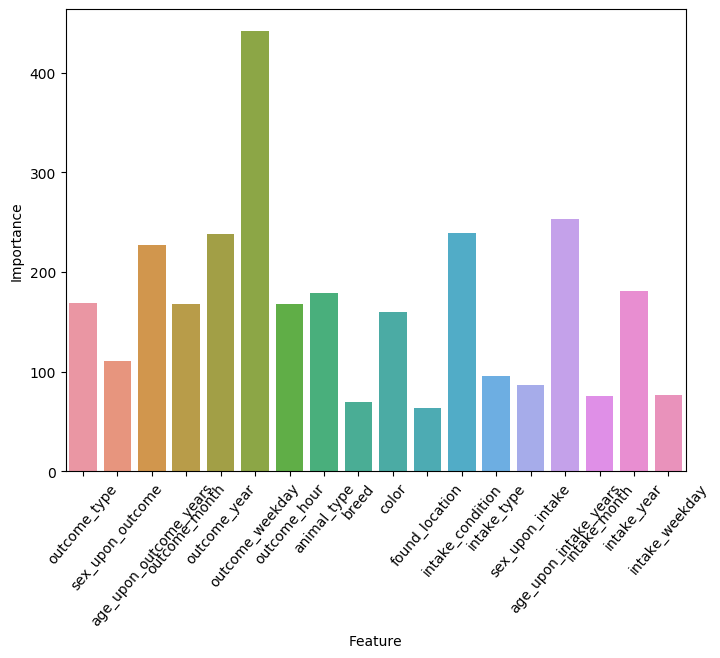

In [54]:
#from benchmark model: https://www.kaggle.com/code/wenlie/exploring-and-predicting-the-animal-s-outcomes
#used in order to study and compare model results:
feat_importance = pd.DataFrame({'Feature':data.columns[:-1],'Importance':clf.feature_importances_.tolist()})

plt.subplots(figsize=(8, 6))
g = sns.barplot(data=feat_importance, x='Feature', y='Importance')
labels = g.get_xticklabels()
g.set_xticklabels(labels,rotation=50)
plt.show(g)